## Reinforcement Learning
### Chapter 6: Temporal-Difference Learning
##### By Yurou He and Ruqing Xu   
##### Mar 12, 2025 

In [20]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [21]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import os

In [22]:
%matplotlib inline
print(os.getcwd())

/Users/yurouhe/Dropbox/PhD/2025 Spring/theory reading group/RLbook2020/python


### 6.2 Advantages of TD Prediction Methods
#### Example 6.2 - Random Walk

In [23]:
# 0 is the left terminal state
# 6 is the right terminal state
# 1 ... 5 represents A ... E
VALUES = np.zeros(7)
VALUES[1:6] = 0.5
VALUES

array([0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0. ])

In [24]:
# The left terminal state has value 0, the right terminal state has value 1
VALUES[6] = 1
VALUES

array([0. , 0.5, 0.5, 0.5, 0.5, 0.5, 1. ])

In [25]:
# True state values
TRUE_VALUE = np.zeros(7)
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUE[6] = 1
TRUE_VALUE

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        ])

In [26]:
# Actions
ACTION_LEFT = 0
ACTION_RIGHT = 1

In [27]:
# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def monte_carlo(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [state]

    # if end up with left terminal state, all returns are 0
    # if end up with right terminal state, all returns are 1
    while True:
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        trajectory.append(state)
        if state == 6:
            returns = 1.0
            break
        elif state == 0:
            returns = 0.0
            break

    if not batch:
        for state_ in trajectory[:-1]:
            # MC update
            values[state_] += alpha * (returns - values[state_])

    return trajectory, [returns] * (len(trajectory) - 1)

In [28]:
# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def temporal_difference(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [state]
    rewards = [0]
    
    # if end up with left terminal state, all returns are 0
    # if end up with right terminal state, all returns are 1
    while True:
        old_state = state
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1

        # Assume all rewards are 0
        reward = 0
        trajectory.append(state)

        # TD update
        if not batch:
            values[old_state] += alpha * (reward + values[state] - values[old_state])
        if state == 6 or state == 0:
            break
        rewards.append(reward)
    return trajectory, rewards

In [29]:
# Example 6.2 - left panel
# Compute state value
def compute_state_value():

    episodes = [0, 1, 10, 100]

    current_values = np.copy(VALUES)

    # Plot simulated state value
    plt.figure(1)
    for i in range(episodes[-1] + 1):
        if i in episodes:
            plt.plot(("A", "B", "C", "D", "E"), current_values[1:6], label=str(i) + ' episodes')
        temporal_difference(current_values)
    
    # Plot true state value
    plt.plot(("A", "B", "C", "D", "E"), TRUE_VALUE[1:6], label='true values')

    plt.xlabel('State')
    plt.ylabel('Estimated Value')
    plt.legend()

In [30]:
# Example 6.2 - right panel
# Function to compute RMS error
def rms_error():

    # Same alpha value can appear in both arrays
    td_alphas = [0.15, 0.1, 0.05]
    mc_alphas = [0.01, 0.02, 0.03, 0.04]

    episodes = 100 + 1
    runs = 100

    for i, alpha in enumerate(td_alphas + mc_alphas):

        total_errors = np.zeros(episodes)

        # Specify methods
        if i < len(td_alphas):
            method = 'TD'
            linestyle = 'solid'
        else:
            method = 'MC'
            linestyle = 'dashdot'

        # Loop over runs and plot RMS errors
        for r in tqdm(range(runs)):
            errors = []
            current_values = np.copy(VALUES)

            # Loop over episodes
            for i in range(0, episodes):

                errors.append(np.sqrt(np.sum(np.power(TRUE_VALUE - current_values, 2)) / 5.0))
                
                # Call TD or MC function
                if method == 'TD':
                    temporal_difference(current_values, alpha=alpha)
                else:
                    monte_carlo(current_values, alpha=alpha)

            total_errors += np.asarray(errors)

        total_errors /= runs
        plt.plot(total_errors, linestyle=linestyle, label=method + ', $\\alpha$ = %.02f' % (alpha))
    
    plt.xlabel('Walks/Episodes')
    plt.ylabel('Empirical RMS error, averaged over states')
    plt.legend()

100%|██████████| 100/100 [00:00<00:00, 1124.76it/s]


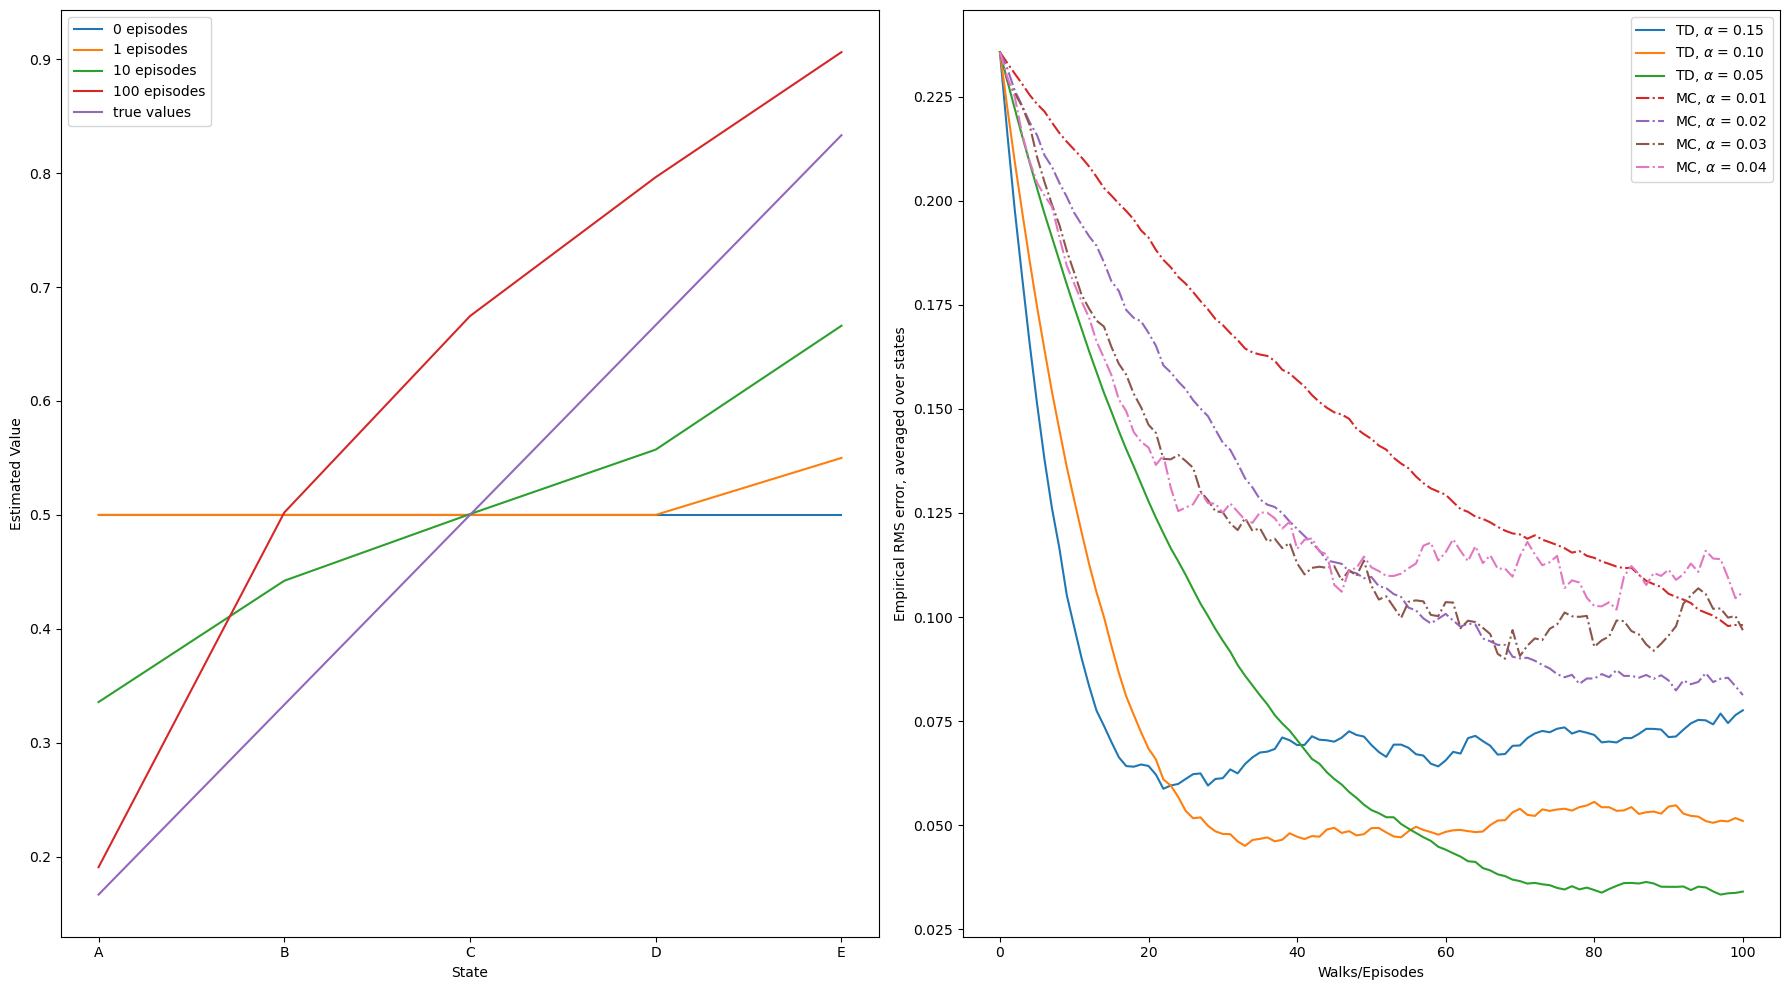

In [31]:
# Plot Figure in Example 6.2
plt.figure(figsize=(18, 10))

# LHS
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
compute_state_value()  # Ensure this function is defined elsewhere

# RHS
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
rms_error()  # Ensure this function is defined elsewhere

# Export
plt.tight_layout()
plt.savefig('images/example_6_2.png')
plt.show()

### 6.3 Optimality of TD (0)
#### Example 6.3 - Random walk under batch updating
##### Batch updating: updates are made only after processing each complete batch of training data

In [32]:
# Compute RMS error by methods
# @method: 'TD' or 'MC'
def batch_updating(method, episodes, alpha=0.001):

    # 100 independent runs
    runs = 100
    total_errors = np.zeros(episodes)

    # Loop over runs
    for r in tqdm(range(0, runs)):
        current_values = np.copy(VALUES)
        current_values[1:6] = -1
        errors = []
        # track shown trajectories and reward/return sequences
        trajectories = []
        rewards = []

        # Loop over episodes
        for ep in range(episodes):

            if method == 'TD':
                trajectory_, rewards_ = temporal_difference(current_values, batch=True)
            else:
                trajectory_, rewards_ = monte_carlo(current_values, batch=True)
            trajectories.append(trajectory_)
            rewards.append(rewards_)

            # keep feeding the algorithm with trajectories seen so far until state value function converges
            while True:
                updates = np.zeros(7)
                for trajectory_, rewards_ in zip(trajectories, rewards):
                    for i in range(0, len(trajectory_) - 1):
                        if method == 'TD':
                            updates[trajectory_[i]] += rewards_[i] + current_values[trajectory_[i + 1]] - current_values[trajectory_[i]]
                        else:
                            updates[trajectory_[i]] += rewards_[i] - current_values[trajectory_[i]]
                updates *= alpha
                if np.sum(np.abs(updates)) < 1e-3:
                    break
                # perform batch updating
                current_values += updates
            # calculate rms error
            errors.append(np.sqrt(np.sum(np.power(current_values - TRUE_VALUE, 2)) / 5.0))

        total_errors += np.asarray(errors)

    total_errors /= runs
    return total_errors

100%|██████████| 100/100 [00:12<00:00,  8.00it/s]


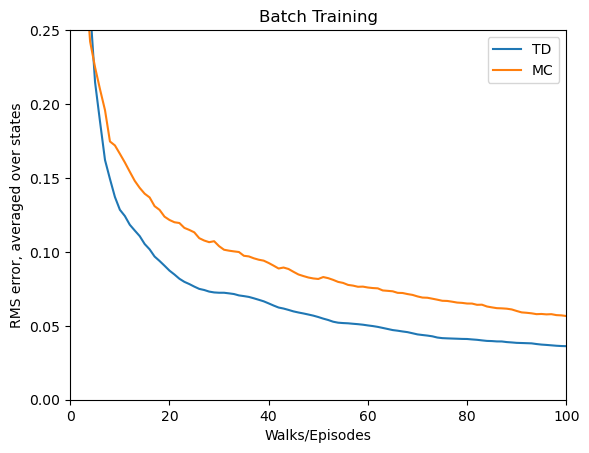

In [33]:
# Plot Figure in Example 6.3
episodes = 100 + 1
td_errors = batch_updating('TD', episodes)
mc_errors = batch_updating('MC', episodes)

plt.plot(td_errors, label='TD')
plt.plot(mc_errors, label='MC')
plt.title("Batch Training")
plt.xlabel('Walks/Episodes')
plt.ylabel('RMS error, averaged over states')
plt.xlim(0, 100)
plt.ylim(0, 0.25)
plt.legend()

plt.savefig('images/figure_6_2.png')
plt.show()

### 6.4 Sarsa: On-policy TD Control
#### Example 6.5 - Windy Grid World

In [34]:
# World height
WORLD_HEIGHT = 7

# World width
WORLD_WIDTH = 10

# Wind strength for each column
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
WIND

[0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

In [35]:
# Start and end locations
START = [3, 0]
GOAL = [3, 7]

# Possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
ACTIONS

[0, 1, 2, 3]

In [36]:
# Function for updating state-action pair
def step(state, action):

    # Current state
    i, j = state
    
    # Update state' with action
    if action == ACTION_UP:
        return [max(i - 1 - WIND[j], 0), j]
    elif action == ACTION_DOWN:
        return [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
    elif action == ACTION_LEFT:
        return [max(i - WIND[j], 0), max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        return [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
    else:
        assert False

In [37]:
# Probability for exploration
EPSILON = 0.1

# Sarsa step size
ALPHA = 0.5

# Reward for each step
REWARD = -1.0

# Function of one episode
def episode(q_value):
    
    # track the total time steps in this episode
    time = 0

    # initialize state
    state = START # [3, 0]

    # choose an action based on epsilon-greedy algorithm
    if np.random.binomial(1, EPSILON) == 1:
        action = np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # keep going until get to the goal state
    while state != GOAL:
        next_state = step(state, action)
        if np.random.binomial(1, EPSILON) == 1:
            next_action = np.random.choice(ACTIONS)
        else:
            values_ = q_value[next_state[0], next_state[1], :]
            next_action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

        # Sarsa update
        q_value[state[0], state[1], action] += \
            ALPHA * (REWARD + q_value[next_state[0], next_state[1], next_action] -
                     q_value[state[0], state[1], action])
        state = next_state
        action = next_action
        time += 1
    return time

In [38]:
# Play 500 episodes
q_value = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4)) # state-action pairs: 4 possible action each state (grid)
episode_limit = 500

steps = []
ep = 0
while ep < episode_limit:
    steps.append(episode(q_value))
    # time = episode(q_value)
    # episodes.extend([ep] * time)
    ep += 1
steps = np.add.accumulate(steps)

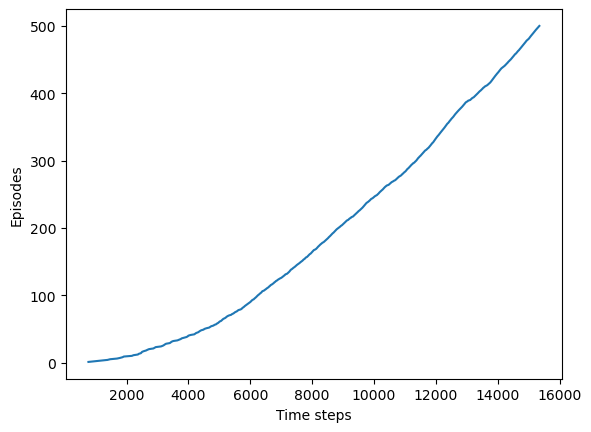

In [39]:
# Plot the time steps
plt.plot(steps, np.arange(1, len(steps) + 1))
plt.xlabel('Time steps')
plt.ylabel('Episodes')

plt.savefig('images/example_6_5.png')
plt.show()

In [40]:
# Display the optimal policy
optimal_policy = []
for i in range(0, WORLD_HEIGHT):
    optimal_policy.append([])
    for j in range(0, WORLD_WIDTH):

        if [i, j] == GOAL:
            optimal_policy[-1].append('G')
            continue
        bestAction = np.argmax(q_value[i, j, :])

        if bestAction == ACTION_UP:
            optimal_policy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimal_policy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimal_policy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimal_policy[-1].append('R')

print('Optimal policy is:')
for row in optimal_policy:
    print(row)
print('Wind strength for each column:\n{}'.format([str(w) for w in WIND]))

Optimal policy is:
['L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'L', 'R', 'R', 'R', 'R', 'R', 'U', 'U', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['D', 'U', 'R', 'R', 'U', 'U', 'R', 'G', 'U', 'D']
['L', 'R', 'R', 'U', 'R', 'R', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'R', 'U', 'U', 'D', 'L', 'D']
['R', 'R', 'U', 'U', 'U', 'U', 'U', 'U', 'L', 'L']
Wind strength for each column:
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


### 6.5 Q-learning: Off-policy TD Control
#### Example 6.6 - Cliff Walking

In [41]:
# Initial state action pair

# States
WORLD_HEIGHT = 4 # World height
WORLD_WIDTH = 12 # World width

# Starting and ending points
START = [3, 0]
GOAL = [3, 11]

# All possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
ACTIONS

[0, 1, 2, 3]

In [42]:
# Function for updating state-action and reward
def step(state, action):

    # Current state
    i, j = state

    # Update state' with action
    if action == ACTION_UP:
        next_state = [max(i - 1, 0), j]
    elif action == ACTION_LEFT:
        next_state = [i, max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_DOWN:
        next_state = [min(i + 1, WORLD_HEIGHT - 1), j]
    else:
        assert False

    # reward for each action in each state
    # actionRewards = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    # actionRewards[:, :, :] = -1.0
    # actionRewards[2, 1:11, ACTION_DOWN] = -100.0
    # actionRewards[3, 0, ACTION_RIGHT] = -100.0

    # Get -1 for one more step
    reward = -1

    # Get -100 if fall off the cliff
    if (action == ACTION_DOWN and i == 2 and 1 <= j <= 10) or (
        action == ACTION_RIGHT and state == START):
        reward = -100
        next_state = START

    return next_state, reward

In [43]:
# Probability for exploration
EPSILON = 0.1

# Step size
ALPHA = 0.5

# Gamma for Q-Learning and Expected Sarsa
GAMMA = 1

In [44]:
# Choose an action by epsilon greedy algorithm
def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

In [45]:
# An episode with Sarsa
# @q_value: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @step_size: step size for updating
# @return: total rewards within this episode
def sarsa(q_value, expected=False, step_size=ALPHA):

    state = START # [3, 0]
    action = choose_action(state, q_value)
    rewards = 0.0

    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, q_value)
        rewards += reward
        
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # Calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target += EPSILON / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        
        state = next_state
        action = next_action
    return rewards

In [46]:
# An episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def qlearning(q_value, step_size=ALPHA):

    state = START
    rewards = 0.0

    while state != GOAL:
        action = choose_action(state, q_value)
        next_state, reward = step(state, action)
        rewards += reward
        
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
    return rewards

In [47]:
# Use multiple runs instead of a single run and a sliding window
# With a single run I failed to present a smooth curve
# However the optimal policy converges well with a single run
# Sarsa converges to the safe path, while Q-Learning converges to the optimal path

# episodes of each run
episodes = 500

# perform 40 independent runs
runs = 50

rewards_sarsa = np.zeros(episodes)
rewards_qlearning = np.zeros(episodes)

# Loop over runs
for r in tqdm(range(runs)):

    # Sarsa
    q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

    # Q-learning
    q_qlearning = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

    for i in range(0, episodes):
        # cut off the value by -100 to draw the figure more elegantly
        # rewards_sarsa[i] += max(sarsa(q_sarsa), -100)
        # rewards_qlearning[i] += max(qlearning(q_qlearning), -100)
        rewards_sarsa[i] += sarsa(q_sarsa)
        rewards_qlearning[i] += qlearning(q_qlearning)

# Averaging over independt runs
rewards_sarsa /= runs
rewards_qlearning /= runs

100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


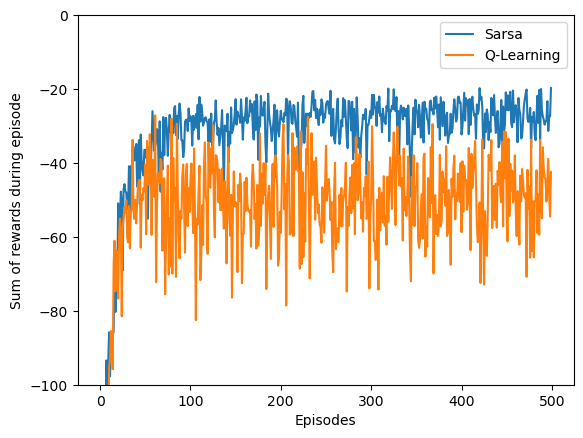

In [48]:
# Plot reward curves
plt.plot(rewards_sarsa, label='Sarsa')
plt.plot(rewards_qlearning, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.ylim([-100, 0])
plt.legend()

plt.savefig('images/figure_6_4.png')
plt.show()

In [49]:
# Print optimal policy
def print_optimal_policy(q_value):

    optimal_policy = []

    # Loop over grid
    for i in range(0, WORLD_HEIGHT):

        optimal_policy.append([])

        for j in range(0, WORLD_WIDTH):

            if [i, j] == GOAL:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_value[i, j, :])

            if bestAction == ACTION_UP:
                optimal_policy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimal_policy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimal_policy[-1].append('R')
                
    for row in optimal_policy:
        print(row)
        
# Optimal policy
print('Sarsa Optimal Policy:')
print_optimal_policy(q_sarsa)
print('Q-Learning Optimal Policy:')
print_optimal_policy(q_qlearning)

Sarsa Optimal Policy:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'R', 'D']
['R', 'R', 'U', 'U', 'U', 'U', 'U', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'L', 'R', 'U', 'U', 'R', 'U', 'U', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-Learning Optimal Policy:
['U', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D', 'D']
['R', 'D', 'R', 'R', 'D', 'D', 'R', 'D', 'D', 'D', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


### 6.6 Expected Sarsa
#### Example 6.6 (cont) - Cliff Walking: Interim and asymptotic performance of TD control methods

In [50]:
# Due to limited capacity of calculation of my machine
# We run 100,000 episodes and 50,000 runs to get the fully averaged performance
# However, even with 1,000 episodes and 10 runs, the curves looks still good
step_sizes = np.arange(0.1, 1.1, 0.1)
episodes = 1000
runs = 10

ASY_SARSA = 0
ASY_EXPECTED_SARSA = 1
ASY_QLEARNING = 2
INT_SARSA = 3
INT_EXPECTED_SARSA = 4
INT_QLEARNING = 5
methods = range(0, 6)
performace = np.zeros((6, len(step_sizes)))

In [51]:
# Loop over runs
for run in range(runs):
    for ind, step_size in tqdm(list(zip(range(0, len(step_sizes)), step_sizes))):

        q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
        q_expected_sarsa = np.copy(q_sarsa)
        q_qlearning = np.copy(q_sarsa)

        # Loop over episode
        for ep in range(episodes):

            sarsa_reward = sarsa(q_sarsa, expected=False, step_size=step_size)
            expected_sarsa_reward = sarsa(q_expected_sarsa, expected=True, step_size=step_size)
            qlearning_reward = qlearning(q_qlearning, step_size=step_size)
            performace[ASY_SARSA, ind] += sarsa_reward
            performace[ASY_EXPECTED_SARSA, ind] += expected_sarsa_reward
            performace[ASY_QLEARNING, ind] += qlearning_reward

            if ep < 100:
                performace[INT_SARSA, ind] += sarsa_reward
                performace[INT_EXPECTED_SARSA, ind] += expected_sarsa_reward
                performace[INT_QLEARNING, ind] += qlearning_reward

performace[:3, :] /= episodes * runs
performace[3:, :] /= 100 * runs

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


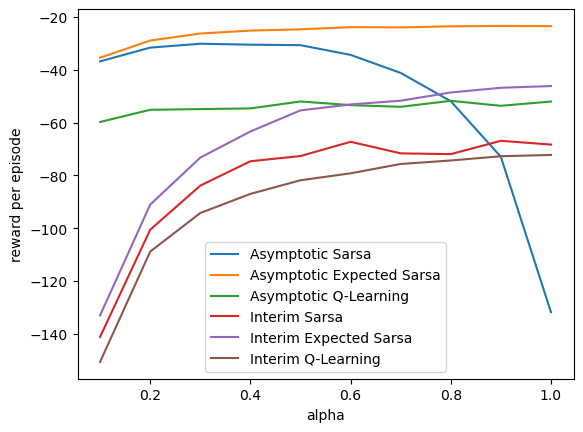

In [52]:
# Plot reward per episode
labels = ['Asymptotic Sarsa', 'Asymptotic Expected Sarsa', 'Asymptotic Q-Learning',
            'Interim Sarsa', 'Interim Expected Sarsa', 'Interim Q-Learning']

for method, label in zip(methods, labels):
    plt.plot(step_sizes, performace[method, :], label=label)
plt.xlabel('alpha')
plt.ylabel('reward per episode')
plt.legend()

plt.savefig('images/figure_6_3.png')
plt.show()

### 6.7 Maximization Bias and Double Learning
#### Comparison of Q-learning and Double Q-learning on a simple episodic MDP

In [53]:
# State A
STATE_A = 0

# State B
STATE_B = 1

# Use one terminal state
STATE_TERMINAL = 2

# Starts from state A
STATE_START = STATE_A

In [54]:
# Possible actions in A
ACTION_A_RIGHT = 0
ACTION_A_LEFT = 1

# Possible actions in B, maybe 10 actions
ACTIONS_B = range(0, 10)

# all possible actions
STATE_ACTIONS = [[ACTION_A_RIGHT, ACTION_A_LEFT], ACTIONS_B]

In [55]:
# Probability for exploration
EPSILON = 0.1

# Step size
ALPHA = 0.1

# Discount for max value
GAMMA = 1.0


In [56]:
# State action pair values, if a state is a terminal state, then the value is always 0
INITIAL_Q = [np.zeros(2), np.zeros(len(ACTIONS_B)), np.zeros(1)]

# Set up destination for each state and each action
TRANSITION = [[STATE_TERMINAL, STATE_B], [STATE_TERMINAL] * len(ACTIONS_B)]

In [57]:
# Choose an action with epsilon greedy algorithm
def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(STATE_ACTIONS[state])
    else:
        values_ = q_value[state]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

In [58]:
# Take @action in @state, return the reward
def take_action(state, action):
    if state == STATE_A:
        return 0
    return np.random.normal(-0.1, 1)

In [59]:
# If there are two state action pair value array, use double Q-Learning
# Otherwise use normal Q-Learning
def qlearning(q1, q2=None):
    state = STATE_START
    # track the # of action left in state A
    left_count = 0
    while state != STATE_TERMINAL:
        if q2 is None:
            action = choose_action(state, q1)
        else:
            # derive a action form Q1 and Q2
            action = choose_action(state, [item1 + item2 for item1, item2 in zip(q1, q2)])
        if state == STATE_A and action == ACTION_A_LEFT:
            left_count += 1
        reward = take_action(state, action)
        next_state = TRANSITION[state][action]
        if q2 is None:
            active_q = q1
            target = np.max(active_q[next_state])
        else:
            if np.random.binomial(1, 0.5) == 1:
                active_q = q1
                target_q = q2
            else:
                active_q = q2
                target_q = q1
            best_action = np.random.choice([action_ for action_, value_ in enumerate(active_q[next_state]) if value_ == np.max(active_q[next_state])])
            target = target_q[next_state][best_action]

        # Q-Learning update
        active_q[state][action] += ALPHA * (
            reward + GAMMA * target - active_q[state][action])
        state = next_state
    return left_count

100%|██████████| 1000/1000 [00:14<00:00, 67.41it/s]


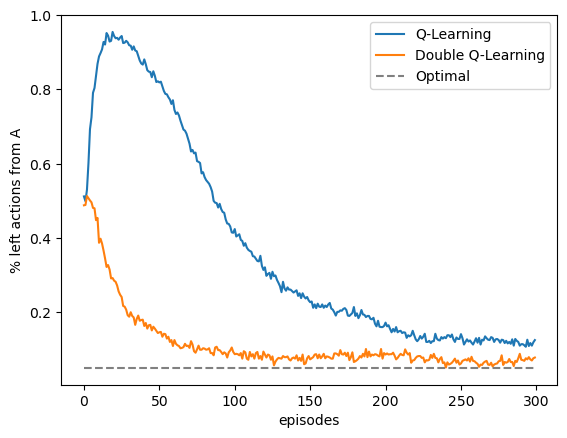

In [60]:
# Plot Figure 6.7: 1,000 runs 
# Number of actions in state B will also affect the curves

# Each independent run has 300 episodes
episodes = 300
runs = 1000
left_counts_q = np.zeros((runs, episodes))
left_counts_double_q = np.zeros((runs, episodes))
for run in tqdm(range(runs)):
    q = copy.deepcopy(INITIAL_Q)
    q1 = copy.deepcopy(INITIAL_Q)
    q2 = copy.deepcopy(INITIAL_Q)
    for ep in range(0, episodes):
        left_counts_q[run, ep] = qlearning(q)
        left_counts_double_q[run, ep] = qlearning(q1, q2)
left_counts_q = left_counts_q.mean(axis=0)
left_counts_double_q = left_counts_double_q.mean(axis=0)

plt.plot(left_counts_q, label='Q-Learning')
plt.plot(left_counts_double_q, label='Double Q-Learning')
plt.plot(np.ones(episodes) * 0.05, linestyle='--', color='gray', label='Optimal')
plt.xlabel('episodes')
plt.ylabel('% left actions from A')
plt.legend()

plt.savefig('images/figure_6_5.png')
plt.show()